# Revamping the barcode plot code so that it's easier to read and has less miscellaneous graphs in it

## This cell loads in the file, parses it, then organizes it into a dataframe. From there, it uses the .json file with dates ("Creation data") to update the years on each recording's date.

In [1]:
import re
import json
import pandas as pd
import ast
import numpy as np
from datetime import datetime

# === File paths ===
recording_file_path_name = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/New_AreaX_lesions/USA5506_decoded_database.json'
path_to_json_file_with_dates = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/New_AreaX_lesions/RC1_USA5506_Comp2_creation_data.json'

# === Extract animal ID from file path ===
match = re.search(r"(USA\d{4})", path_to_json_file_with_dates)
if match:
    animal_id = match.group(1)
    print(f"Animal ID: {animal_id}")
else:
    print("Animal ID not found in the file path.")

# === Load JSON metadata and treatment date ===
with open(path_to_json_file_with_dates, 'r') as f:
    json_data = json.load(f)

json_treatment_date = json_data['treatment_date']
date_obj = datetime.strptime(json_treatment_date, "%Y-%m-%d")
treatment_date = date_obj.strftime("%Y.%m.%d")
print(f"Treatment date: {treatment_date}")

# === Define loader class ===
class temp:
    def __init__(self):
        print(f"Reading JSON file: {recording_file_path_name}")
        with open(recording_file_path_name, 'r') as f:
            decoder_data = json.load(f)['results']

        print(f"Total songs in JSON: {len(decoder_data)}")
        decoder_dataframe = pd.DataFrame(decoder_data)
        decoder_dataframe['syllable_onsets_offsets_ms'] = decoder_dataframe['syllable_onsets_offsets_ms'].apply(self.parse_json_safe)
        decoder_dataframe['syllable_onsets_offsets_timebins'] = decoder_dataframe['syllable_onsets_offsets_timebins'].apply(self.parse_json_safe)
        self.dataframe = decoder_dataframe

    def return_dataframe(self):
        return self.dataframe

    def parse_json_safe(self, s):
        if isinstance(s, dict):
            return s
        if pd.isna(s):
            return {}
        s = s.strip()
        if s.startswith("''") and s.endswith("''"):
            s = s[2:-2]
        elif s.startswith("'") and s.endswith("'"):
            s = s[1:-1]
        if not s:
            return {}
        try:
            return json.loads(s.replace("'", '"'))
        except json.JSONDecodeError:
            try:
                return ast.literal_eval(s)
            except (ValueError, SyntaxError) as e:
                print(f"Error parsing string: {s}\nError: {e}")
                return {}

TEMP = temp()
decoder_dataframe = TEMP.return_dataframe()

# === Load subdirectory creation dates ===
subdirectory_dates = {
    subdir: data['subdirectory_creation_date']
    for subdir, data in json_data['subdirectories'].items()
}

# === Extract metadata from filenames ===
def find_recording_dates_and_times(file_path):
    try:
        file_name = file_path.split('/')[-1]
        parts = file_name.split('_')
        animal_id = parts[0]
        month = parts[2].zfill(2)
        day = parts[3].zfill(2)
        date = f"{month}.{day}"
        hour = parts[4].zfill(2)
        minute = parts[5].zfill(2)
        second = parts[6].replace('.wav', '').zfill(2)
        return animal_id, date, hour, minute, second
    except IndexError:
        print(f"Error: Unexpected format in file name {file_path}")
        return None, None, None, None, None

# === Match full date using both month and day ===
def update_date_with_year(row, subdirectory_dates):
    month_day = row['Date']
    if pd.isna(month_day):
        return None
    month, day = month_day.split('.')
    for subdir, date in subdirectory_dates.items():
        year, json_month, json_day = date.split('-')
        if json_month == month and json_day == day:
            return f"{year}.{month}.{day}"
    return None

# === Main table construction ===
def make_table(input_df, subdirectory_dates):
    input_df = input_df.reset_index(drop=True)
    num_files = input_df.shape[0]

    organized_df = input_df.copy()
    for col in ['Animal ID', 'Date', 'Hour', 'Minute', 'Second']:
        organized_df[col] = [None] * num_files

    for i, row in input_df.iterrows():
        file_path = row['file_name']
        animal_id, date, hour, minute, second = find_recording_dates_and_times(file_path)
        organized_df.at[i, 'Animal ID'] = animal_id
        organized_df.at[i, 'Date'] = date
        organized_df.at[i, 'Hour'] = hour
        organized_df.at[i, 'Minute'] = minute
        organized_df.at[i, 'Second'] = second

    organized_df['Date'] = organized_df.apply(lambda row: update_date_with_year(row, subdirectory_dates), axis=1)
    organized_df['Date'] = pd.to_datetime(organized_df['Date'], format='%Y.%m.%d', errors='coerce')
    print(f"First rows of organized_data_frame with updated dates:\n{organized_df.head(3)}")
    return organized_df

# === Generate organized data table ===
organized_data_frame = make_table(decoder_dataframe, subdirectory_dates)

# === Find unique recording dates ===
def find_unique_recording_dates(df):
    return df['Date'].dt.strftime('%Y.%m.%d').dropna().unique()

unique_dates = find_unique_recording_dates(organized_data_frame)
print("Unique recording dates:", unique_dates)

# === Extract all unique syllable labels ===
organized_data_frame['syllable_onsets_offsets_ms_dict'] = organized_data_frame['syllable_onsets_offsets_ms']
unique_syllable_labels = set()

for row in organized_data_frame['syllable_onsets_offsets_ms_dict']:
    if row:
        unique_syllable_labels.update(row.keys())

unique_syllable_labels = sorted(unique_syllable_labels)
print("Unique syllable labels:", unique_syllable_labels)


# === Add a column listing syllables present in each file ===
def extract_syllables_present(row):
    if isinstance(row, dict):
        return sorted(list(row.keys()))
    return []

organized_data_frame['syllables_present'] = organized_data_frame['syllable_onsets_offsets_ms_dict'].apply(extract_syllables_present)

# Preview updated DataFrame
print(organized_data_frame[['file_name', 'syllables_present']].head())


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Animal ID: USA5506
Treatment date: 2025.03.04
Reading JSON file: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/New_AreaX_lesions/USA5506_decoded_database.json
Total songs in JSON: 28218
First rows of organized_data_frame with updated dates:
                                  file_name        creation_date  \
0  USA5506_45700.49992595_2_12_13_53_12.wav  2025-02-12T13:53:38   
1  USA5506_45700.50054645_2_12_13_54_14.wav  2025-02-12T13:54:36   
2  USA5506_45700.500

In [2]:
print(unique_dates)

['2025.02.26' '2025.03.18' '2025.03.10' '2025.03.27' '2025.04.08'
 '2025.04.03']


### Find  the order of syllables in each recording.

In [3]:
# === Add a column that shows syllable order in each song ===
def extract_syllable_order(row):
    if not isinstance(row, dict) or not row:
        return []

    onset_syllable_list = []

    for syllable, intervals in row.items():
        for interval in intervals:
            if isinstance(interval, list) and len(interval) >= 1:
                onset_time = interval[0]
                onset_syllable_list.append((onset_time, syllable))

    # Sort by onset time
    onset_syllable_list.sort()
    syllable_order = [syllable for onset, syllable in onset_syllable_list]

    return syllable_order

organized_data_frame['syllable_order'] = organized_data_frame['syllable_onsets_offsets_ms_dict'].apply(extract_syllable_order)

# Preview the result
print(organized_data_frame[['file_name', 'syllables_present', 'syllable_order']])


                                      file_name         syllables_present  \
0      USA5506_45700.49992595_2_12_13_53_12.wav            [11, 12, 2, 5]   
1      USA5506_45700.50054645_2_12_13_54_14.wav           [10, 11, 12, 2]   
2      USA5506_45700.50081602_2_12_13_54_41.wav  [10, 11, 12, 2, 4, 5, 9]   
3       USA5506_45700.50100051_2_12_13_55_0.wav  [10, 11, 12, 2, 4, 5, 9]   
4      USA5506_45700.50124662_2_12_13_55_24.wav  [1, 10, 11, 12, 2, 4, 8]   
...                                         ...                       ...   
28213    USA5506_45754.68665568_4_7_19_4_25.wav                        []   
28214    USA5506_45754.68677458_4_7_19_4_37.wav                        []   
28215    USA5506_45754.68698298_4_7_19_4_58.wav                        []   
28216     USA5506_45754.68707148_4_7_19_5_7.wav                        []   
28217    USA5506_45754.68715018_4_7_19_5_15.wav                        []   

                                     syllable_order  
0                    

# visualize the syllable frequency

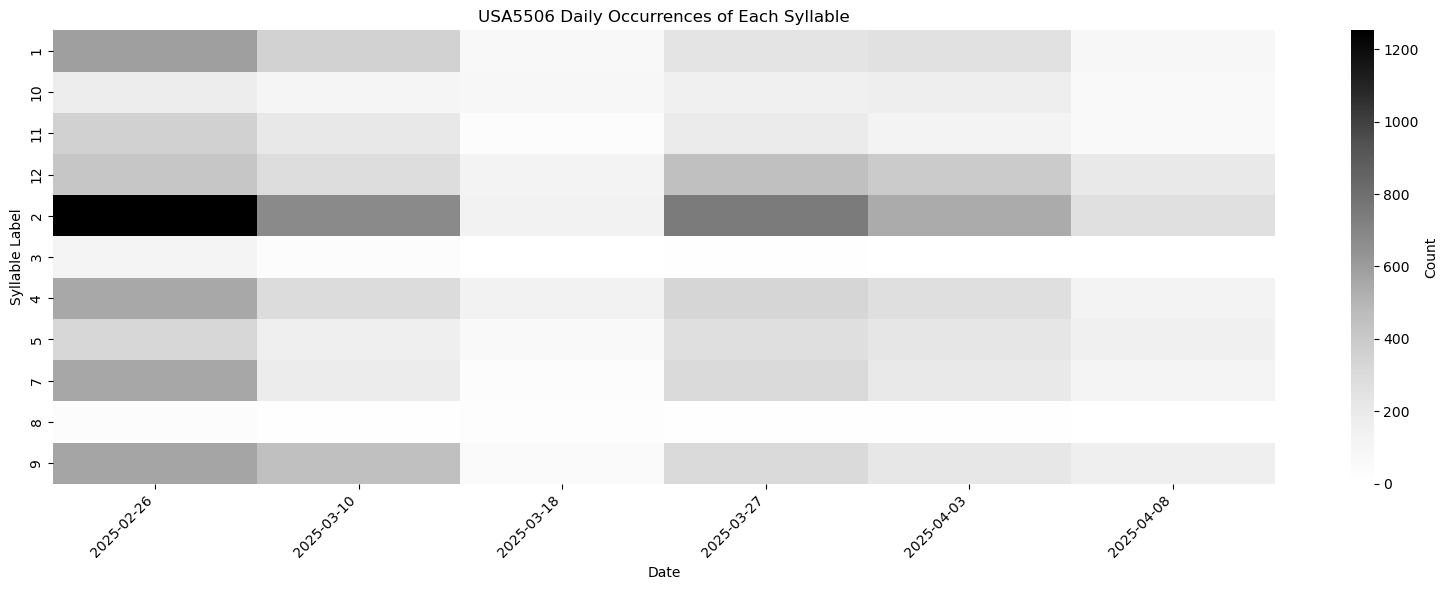

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def count_syllables_per_day(df, unique_dates):
    all_rows = []

    for _, row in df.iterrows():
        date = row['Date']
        if pd.isna(date):
            continue
        for syllable in row['syllable_order']:
            all_rows.append({'Date': date, 'Syllable': syllable})

    syllable_df = pd.DataFrame(all_rows)

    # Count how many times each syllable occurred each day
    count_table = pd.crosstab(index=syllable_df['Syllable'], columns=syllable_df['Date'])

    # Ensure all expected dates are present
    expected_dates = pd.to_datetime(unique_dates)
    for date in expected_dates:
        if date not in count_table.columns:
            count_table[date] = 0

    # Ensure syllables that never appear still show up as rows
    all_syllables = sorted({s for row in df['syllable_order'] if isinstance(row, list) for s in row})
    for syll in all_syllables:
        if syll not in count_table.index:
            count_table.loc[syll] = 0

    # Sort both axes
    count_table = count_table.sort_index(axis=0)  # syllables
    count_table = count_table[sorted(count_table.columns)]  # dates

    return count_table

def plot_syllable_counts(count_table, animal_id=None, treatment_date=None):
    plt.figure(figsize=(16, 6))
    ax = sns.heatmap(count_table, cmap='Greys', cbar_kws={'label': 'Count'})

    # Format x-axis ticks to show only the date
    formatted_dates = [d.strftime('%Y-%m-%d') for d in count_table.columns]
    ax.set_xticklabels(formatted_dates, rotation=45, ha='right')

    plt.xlabel("Date")
    plt.ylabel("Syllable Label")

    if animal_id:
        plt.title(f"{animal_id} Daily Occurrences of Each Syllable")

    if treatment_date:
        treatment_date = pd.to_datetime(treatment_date)
        if treatment_date in count_table.columns:
            index = list(count_table.columns).index(treatment_date)
            ax.axvline(x=index, color='red', linestyle='--', linewidth=2)

    plt.tight_layout()
    plt.show()

# === Usage Example ===
count_table = count_syllables_per_day(organized_data_frame, unique_dates)
plot_syllable_counts(count_table, animal_id="USA5506")


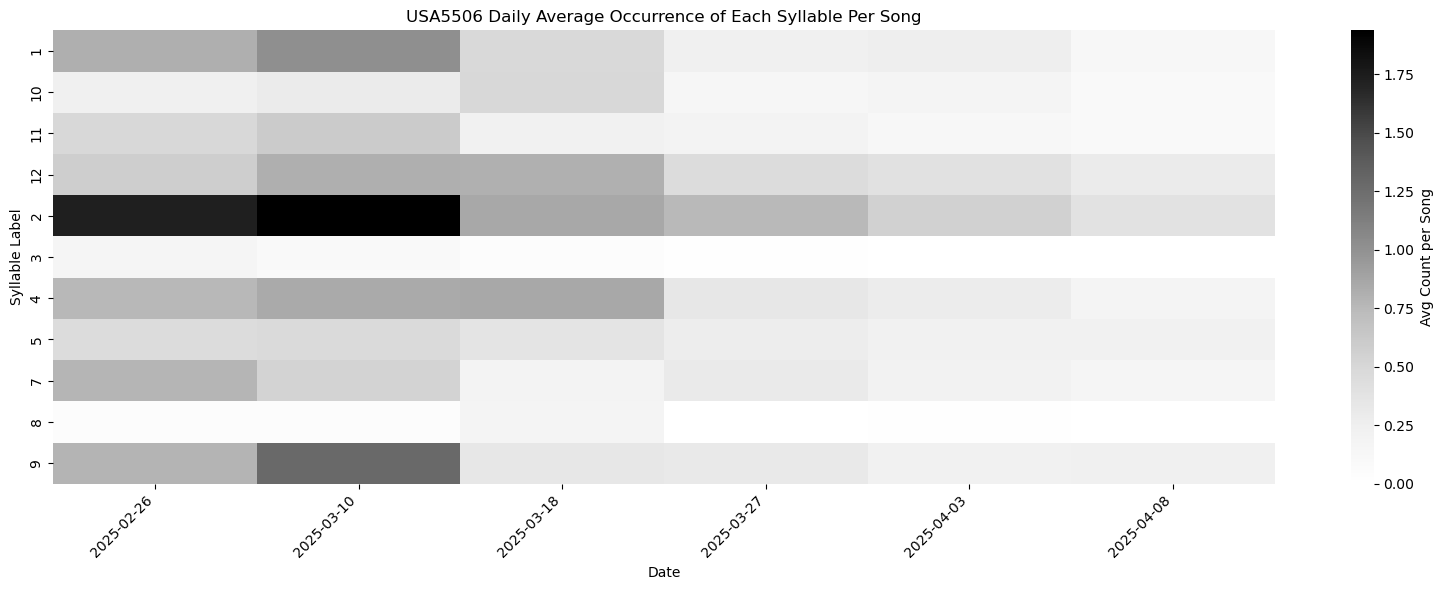

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def count_syllables_per_day(df, unique_dates):
    all_rows = []

    for _, row in df.iterrows():
        date = row['Date']
        if pd.isna(date):
            continue
        for syllable in row['syllable_order']:
            all_rows.append({'Date': date, 'Syllable': syllable})

    syllable_df = pd.DataFrame(all_rows)

    # Count how many times each syllable occurred each day
    count_table = pd.crosstab(index=syllable_df['Syllable'], columns=syllable_df['Date'])

    # Ensure all expected dates are present
    expected_dates = pd.to_datetime(unique_dates)
    for date in expected_dates:
        if date not in count_table.columns:
            count_table[date] = 0

    # Ensure syllables that never appear still show up as rows
    all_syllables = sorted({s for row in df['syllable_order'] if isinstance(row, list) for s in row})
    for syll in all_syllables:
        if syll not in count_table.index:
            count_table.loc[syll] = 0

    # Sort both axes
    count_table = count_table.sort_index(axis=0)  # syllables
    count_table = count_table[sorted(count_table.columns)]  # dates

    # === Normalize by number of songs per day ===
    songs_per_day = df.groupby('Date').size().reindex(expected_dates, fill_value=0)
    for date in count_table.columns:
        if songs_per_day[date] > 0:
            count_table[date] = count_table[date] / songs_per_day[date]
        else:
            count_table[date] = 0

    return count_table

def plot_syllable_counts(count_table, animal_id=None, treatment_date=None):
    plt.figure(figsize=(16, 6))
    ax = sns.heatmap(count_table, cmap='Greys', cbar_kws={'label': 'Avg Count per Song'})

    # Format x-axis ticks and center them on heatmap cells
    ax.set_xticks([i + 0.5 for i in range(len(count_table.columns))])
    formatted_dates = [d.strftime('%Y-%m-%d') for d in count_table.columns]
    ax.set_xticklabels(formatted_dates, rotation=45, ha='right')

    plt.xlabel("Date")
    plt.ylabel("Syllable Label")

    if animal_id:
        plt.title(f"{animal_id} Daily Average Occurrence of Each Syllable Per Song")

    if treatment_date:
        treatment_date = pd.to_datetime(treatment_date).normalize()
        normalized_columns = [col.normalize() for col in count_table.columns]

        if treatment_date in normalized_columns:
            index = normalized_columns.index(treatment_date)
            ax.axvline(x=index + 0.5, color='red', linestyle='--', linewidth=2)  # Center of cell

    plt.tight_layout()
    plt.show()

# === Example Usage ===
# unique_dates must be a list like ['2025.01.01', '2025.01.02', ...]
# treatment_date should be a string like "2025-02-20"

count_table = count_syllables_per_day(organized_data_frame, unique_dates)
plot_syllable_counts(count_table, animal_id="USA5506")


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_log_scaled_syllable_counts(count_table, animal_id=None, treatment_date=None):
    # Apply log10 transform (add small value to avoid log(0))
    log_scaled_table = np.log10(count_table + 1e-3)  # 1e-3 keeps 0s from becoming -inf

    plt.figure(figsize=(16, 6))
    ax = sns.heatmap(log_scaled_table, cmap='Greys', cbar_kws={'label': 'Log10 Avg Count per Song'})

    # Format x-axis labels to just show date
    formatted_dates = [d.strftime('%Y-%m-%d') for d in log_scaled_table.columns]
    ax.set_xticklabels(formatted_dates, rotation=45, ha='right')

    plt.xlabel("Date")
    plt.ylabel("Syllable Label")

    if animal_id:
        plt.title(f"{animal_id} Daily Avg Occurrence of Each Syllable (Log_{10} Scale)")

    if treatment_date:
        treatment_date = pd.to_datetime(treatment_date)
        if treatment_date in log_scaled_table.columns:
            index = list(log_scaled_table.columns).index(treatment_date)
            ax.axvline(x=index, color='red', linestyle='--', linewidth=2)

    plt.tight_layout()
    plt.show()



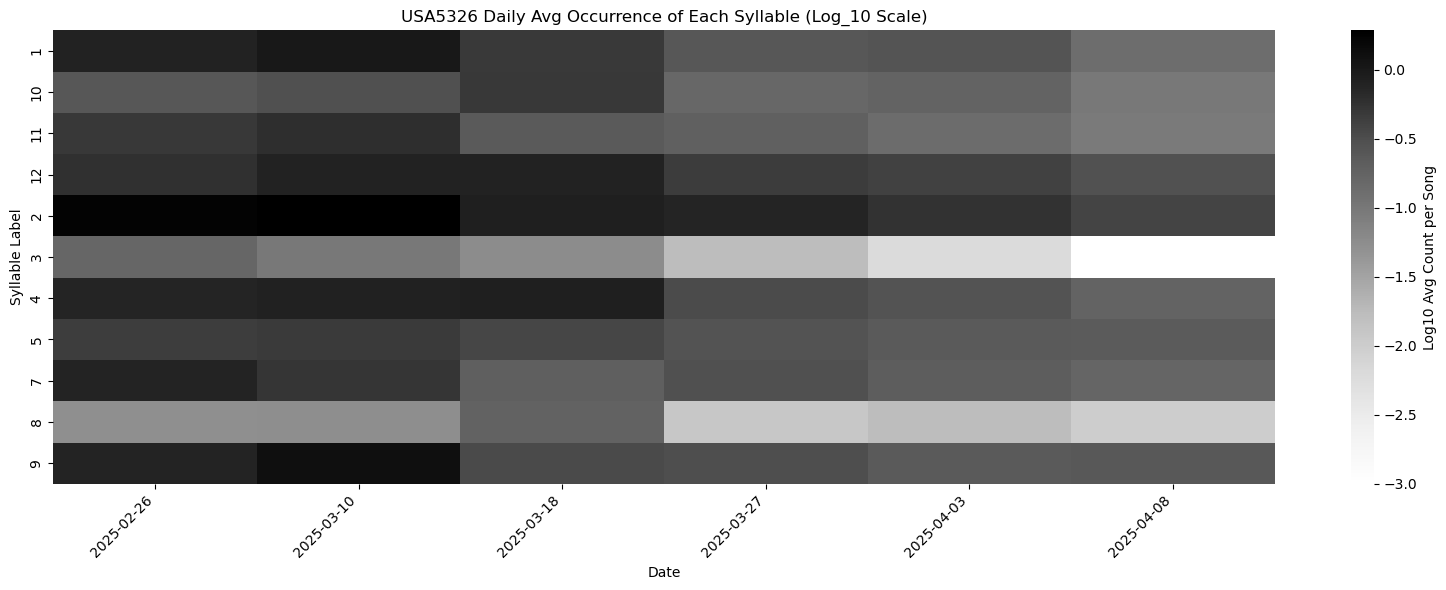

In [7]:
plot_log_scaled_syllable_counts(count_table, animal_id="USA5326", treatment_date="2024-02-20")